In [51]:
import pandas as pd
import numpy as np

from sklearn.linear_model import Ridge

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline, FeatureUnion

import matplotlib.pyplot as plt
import seaborn as sbr
sbr.set(font_scale=1.2)
 
%matplotlib inline

###  Helpers

In [75]:
def make_submission(model, file_index):
    """Create submission for publick score
    
    Args:
        model: The trained model
        file_index (str): The name of the file
    """
    test_preds = model.predict(prepared_test)
    sample_submission = pd.read_csv('submissions/sample_submission.csv', index_col='url')
    
    new_sumb = sample_submission.copy()
    new_sumb['favs_lognorm'] = test_preds
    new_sumb.to_csv('submissions/submission_{}.csv'.format(file_index))
    
    print('submission_{}.csv successfully created'.format(file_index))

In [53]:
def estimate_model(model):
    """Evaluate model for the training and cross-validation datasets

    Args:
        model : The trained model
    """
    print('Train error:', mean_squared_error(y_train, model.predict(X_train)))
    print('Test error:', mean_squared_error(y_test, model.predict(X_test)))

In [54]:
# http://scikit-learn.org/stable/auto_examples/hetero_feature_union.html
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    >> len(data[key]) == n_samples

    Please note that this is the opposite convention to scikit-learn feature
    matrixes (where the first index corresponds to sample).

    ItemSelector only requires that the collection implement getitem
    (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
    DataFrame, numpy record array, etc.

    >> data = {'a': [1, 5, 2, 5, 2, 8],
               'b': [9, 4, 1, 4, 1, 3]}
    >> ds = ItemSelector(key='a')
    >> data['a'] == ds.transform(data)

    ItemSelector is not designed to handle data grouped by sample.  (e.g. a
    list of dicts).  If your data is structured this way, consider a
    transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

### Load data

In [55]:
train_df = pd.read_csv('data/howpop_train.csv')
test_df  = pd.read_csv('data/howpop_test.csv')

### Analyzation of the raw data

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134137 entries, 0 to 134136
Data columns (total 17 columns):
url                 134137 non-null object
domain              134137 non-null object
post_id             134137 non-null int64
published           134137 non-null object
author              97657 non-null object
flow                97048 non-null object
polling             134137 non-null bool
content_len         134137 non-null int64
title               134137 non-null object
comments            134137 non-null int64
favs                134137 non-null int64
views               134137 non-null int64
votes_plus          133566 non-null float64
votes_minus         133566 non-null float64
views_lognorm       134137 non-null float64
favs_lognorm        134137 non-null float64
comments_lognorm    134137 non-null float64
dtypes: bool(1), float64(5), int64(5), object(6)
memory usage: 16.5+ MB


In [7]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
post_id,134137.0,181307.054265,81766.350702,18284.000000,115565.000000,182666.000000,257401.000000,3.140880e+05
content_len,134137.0,7516.929699,8724.771640,1.000000,2179.000000,4949.000000,9858.000000,3.524710e+05
comments,134137.0,39.625994,62.398958,0.000000,7.000000,19.000000,48.000000,2.266000e+03
favs,134137.0,71.999866,145.854135,0.000000,8.000000,27.000000,78.000000,8.718000e+03
views,134137.0,16631.013084,31479.819691,3.000000,2100.000000,7600.000000,18700.000000,1.730000e+06
votes_plus,133566.0,35.536888,42.461073,0.000000,11.000000,22.000000,45.000000,1.466000e+03
votes_minus,133566.0,8.050035,11.398282,0.000000,2.000000,5.000000,10.000000,4.450000e+02
views_lognorm,134137.0,0.004849,1.002158,-6.615254,-0.706552,-0.020934,0.682689,5.182821e+00
favs_lognorm,134137.0,0.003402,1.002778,-4.137662,-0.695780,0.007022,0.708778,4.872866e+00
comments_lognorm,134137.0,-0.003675,1.005259,-4.161967,-0.633775,0.072082,0.697072,3.900973e+00


#### Some authors are missing

In [14]:
# train
print(train_df[train_df.author.isnull()].shape[0])
print(train_df.shape[0])

36480
134137


In [4]:
# testing
print(test_df[test_df.author.isnull()].shape[0])
print(test_df.shape[0])

1604
3990


In [6]:
# empty 'autor' means the company blog
train_df[train_df.author.isnull()].head(1)

,url,domain,post_id,published,author,flow,polling,content_len,title,comments,favs,views,votes_plus,votes_minus,views_lognorm,favs_lognorm,comments_lognorm
77,https://habrahabr.ru/company/usabilitylab/blog...,habrahabr.ru,18501,2008-01-10 05:54:00,NaN,misc,False,4097,Анатолий Костин. Эта непредсказуемая автоматика,135,8,1000,36.0,22.0,0.27683,0.25759,1.293633


#### Domain

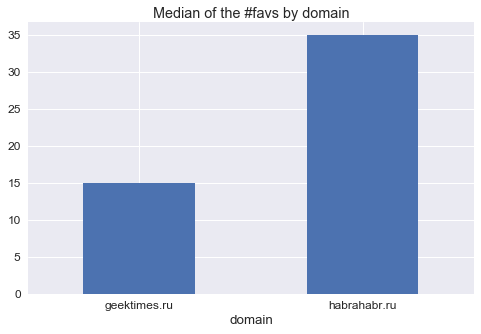

In [8]:
plt.figure(figsize=(8, 5))
train_df.groupby('domain').favs.median().plot.bar()
plt.title('Median of the #favs by domain')
plt.xticks(rotation='horizontal');

#### Flow

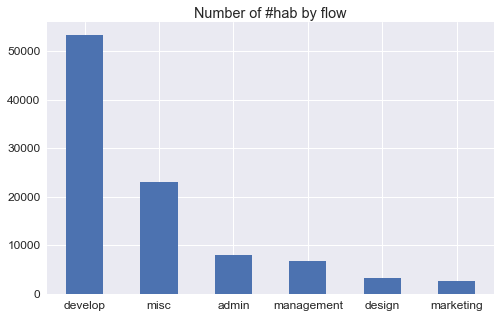

In [9]:
plt.figure(figsize=(8, 5))
train_df.flow.value_counts().plot.bar();
plt.title('Number of #hab by flow')
plt.xticks(rotation='horizontal');

# mostly habs are from the developer flow

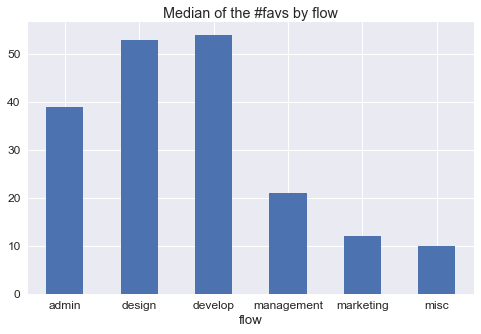

In [10]:
plt.figure(figsize=(8, 5))
train_df.groupby('flow').favs.median().plot.bar()
plt.title('Median of the #favs by flow');
plt.xticks(rotation='horizontal');

#### Polling

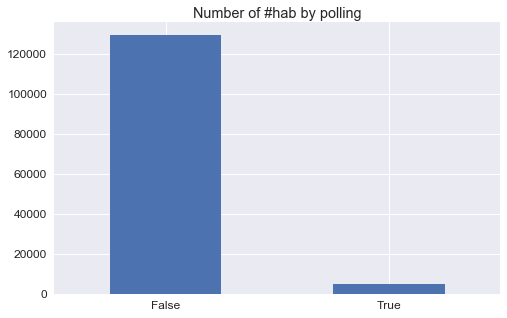

In [11]:
plt.figure(figsize=(8, 5))
train_df.polling.value_counts().plot.bar();
plt.title('Number of #hab by polling')
plt.xticks(rotation='horizontal');

# seems unuseful feature

#### Comments

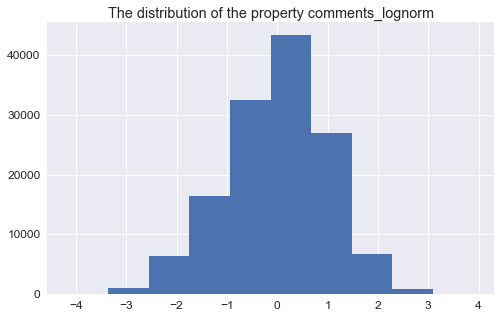

In [12]:
plt.figure(figsize=(8, 5))
plt.hist(train_df.comments_lognorm);
plt.title('The distribution of the property comments_lognorm');

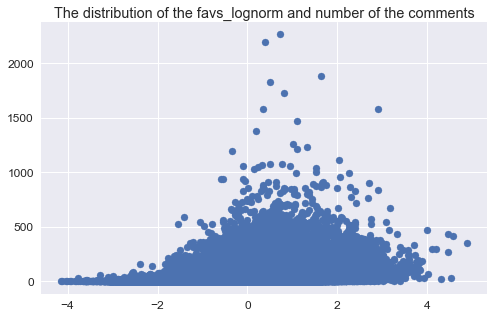

In [214]:
plt.figure(figsize=(8, 5))
plt.scatter(train_df.favs_lognorm, train_df.comments);
plt.title('The distribution of the favs_lognorm and number of the comments');
# outliers?

#### Views

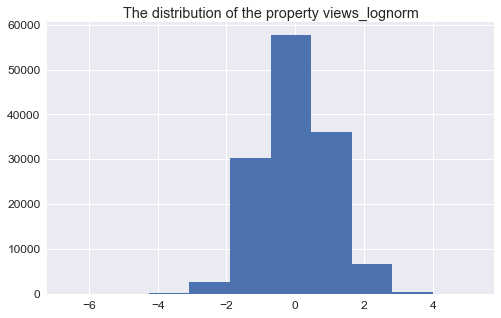

In [201]:
plt.figure(figsize=(8, 5))
plt.hist(train_df.views_lognorm);
plt.title('The distribution of the property views_lognorm');

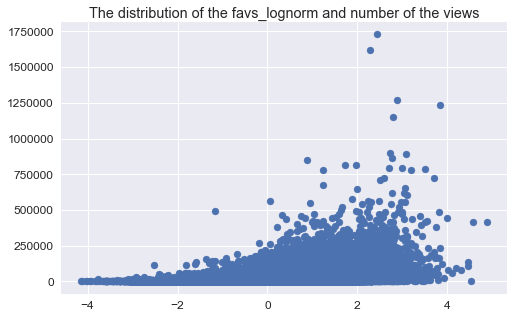

In [204]:
plt.figure(figsize=(8, 5))
plt.scatter(train_df.favs_lognorm, train_df.views);
plt.title('The distribution of the favs_lognorm and number of the views');

# outliers?

#### favs_lognorm

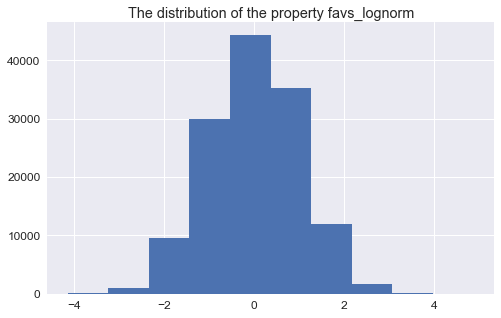

In [203]:
plt.figure(figsize=(8, 5))
plt.hist(train_df.favs_lognorm);
plt.title('The distribution of the property favs_lognorm');

In [127]:
train_df[['comments', 'favs', 'views', 'views_lognorm', 'comments_lognorm', 'favs_lognorm']].corr()

,comments,favs,views,views_lognorm,comments_lognorm,favs_lognorm
comments,1.000000,0.164166,0.290035,0.349568,0.662740,0.278942
favs,0.164166,1.000000,0.634304,0.456097,0.263239,0.587982
views,0.290035,0.634304,1.000000,0.585105,0.326427,0.406782
views_lognorm,0.349568,0.456097,0.585105,1.000000,0.546530,0.688811
comments_lognorm,0.662740,0.263239,0.326427,0.546530,1.000000,0.479476
favs_lognorm,0.278942,0.587982,0.406782,0.688811,0.479476,1.000000


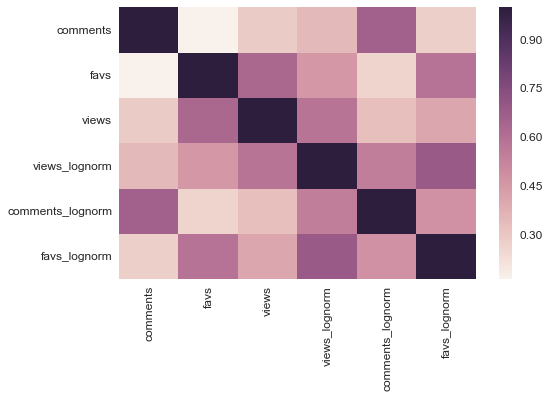

In [14]:
plt.figure(figsize=(8, 5))
sbr.heatmap(train_df[['comments', 'favs', 'views', 'views_lognorm', 'comments_lognorm', 'favs_lognorm']].corr());

### Feature engineering

#### Encoding for years and monthes

In [56]:
full_df = pd.concat([train_df, test_df])

years = full_df.published.apply(lambda p: pd.to_datetime(p).year).unique()
year_encoder = OneHotEncoder()
year_encoder.fit(years.reshape(-1, 1));

months = train_df.published.apply(lambda p: pd.to_datetime(p).month).unique()
month_encoder = OneHotEncoder()
month_encoder.fit(months.reshape(-1, 1));

In [57]:
def encode_column(df, encoder, column_name):
    encoding_column = encoder.transform(df[column_name].values.reshape(-1, 1))
    
    encoded_df = pd.DataFrame(
        index=df.index,
        columns=[column_name + '_' + str(y) for y in encoder.active_features_],
        data=encoding_column.toarray()
    )
    
    return encoded_df

In [58]:
def is_weekend(weekday):
    return weekday == 5 or weekday == 6

In [59]:
def fill_in_author(urls):
    '''Get name of the company from the url'''
    return urls.str.rsplit('/', expand=True)[4]

In [60]:
def create_feature(df):
    df['domain'] = LabelEncoder().fit_transform(df.domain)
        
    # get len of title
    df['title_len'] = df.title.apply(lambda t: len(t))
    
    # scale for length for title and content
    scaler = StandardScaler()
    df[['title_len', 'content_len']] = scaler.fit_transform(df[['title_len', 'content_len']])
    
    # fill in author for companies
    df.author.fillna(fill_in_author(df[df.author.isnull()].url), inplace=True)
    
    # check is it commpany
    df['is_company'] = df.url.str.contains('company')
    df['is_company'] = df.is_company.astype(int)
    
    # get features from published day
    df['hour'] = df.published.apply(lambda p: pd.to_datetime(p).hour)
    df['weekday'] = df.published.apply(lambda p: pd.to_datetime(p).weekday())
    df['month'] = df.published.apply(lambda p: pd.to_datetime(p).month)
    df['year'] = df.published.apply(lambda p: pd.to_datetime(p).year)
    
    # check is published day is weekend
    df['is_weekend'] = df.weekday.apply(lambda w: is_weekend(w)) 
    df['is_weekend'] = df.is_weekend.astype(int)
    
    # one hot encoding for the categorical features
    dummy_cols = ['hour', 'weekday', 'flow']
    
    dummy_df = pd.get_dummies(
        data=df[dummy_cols], columns=dummy_cols, prefix=dummy_cols
    )
    df = pd.concat([df, dummy_df], axis=1)
    del dummy_df    

    year_encode_df = encode_column(df, year_encoder, 'year')
    df = pd.concat([df, year_encode_df], axis=1)
    del year_encode_df
    
    months_encode_df = encode_column(df, month_encoder, 'month')
    df = pd.concat([df, months_encode_df], axis=1)
    del months_encode_df
    
    return df

In [61]:
%%time

prepared_train = create_feature(train_df)
# prepared_train.to_csv('data/prepared_train.csv', index=False)

CPU times: user 38.6 s, sys: 28 ms, total: 38.6 s
Wall time: 38.8 s


In [62]:
%%time

prepared_test = create_feature(test_df)
# prepared_test.to_csv('data/prepared_test.csv', index=False)

CPU times: user 1.18 s, sys: 0 ns, total: 1.18 s
Wall time: 1.18 s


### Analyze new features

              is_company  is_weekend  title_len  content_len  favs_lognorm
is_company      1.000000   -0.135905   0.097516     0.096229     -0.169276
is_weekend     -0.135905    1.000000  -0.006420    -0.008993      0.069757
title_len       0.097516   -0.006420   1.000000     0.070714     -0.076303
content_len     0.096229   -0.008993   0.070714     1.000000      0.356481
favs_lognorm   -0.169276    0.069757  -0.076303     0.356481      1.000000


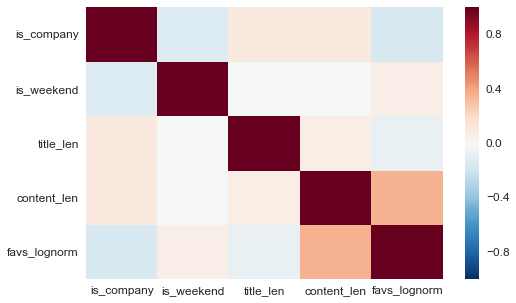

In [188]:
plt.figure(figsize=(8, 5))
sbr.heatmap(train_df[['is_company', 'is_weekend', 'title_len', 'content_len', 'favs_lognorm']].corr());
print(train_df[['is_company', 'is_weekend', 'title_len', 'content_len', 'favs_lognorm']].corr())

#### Published

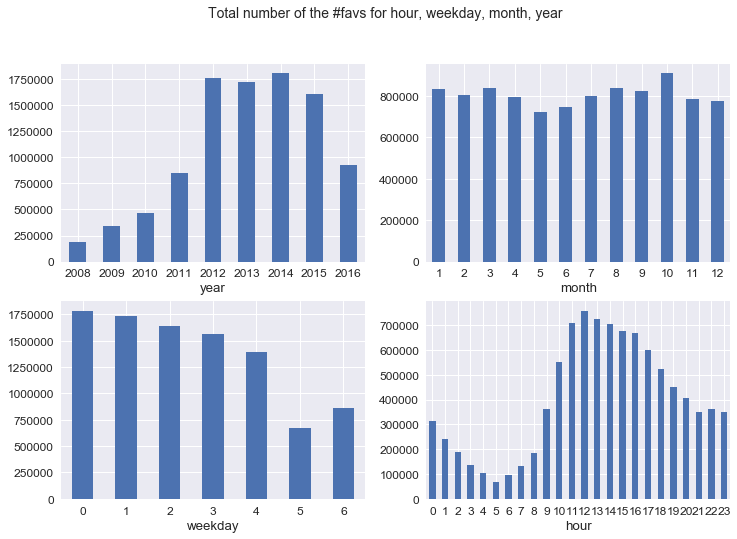

In [184]:
plt.figure(figsize=(12, 8))
plt.suptitle('Total number of the #favs for hour, weekday, month, year', fontsize=14)

plt.subplot(221)
prepared_train.groupby('year').favs.sum().plot.bar();
plt.xticks(rotation='horizontal');

plt.subplot(222)
prepared_train.groupby('month').favs.sum().plot.bar();
plt.xticks(rotation='horizontal');

plt.subplot(223)
prepared_train.groupby('weekday').favs.sum().plot.bar();
plt.xticks(rotation='horizontal');

plt.subplot(224)
prepared_train.groupby('hour').favs.sum().plot.bar();
plt.xticks(rotation='horizontal');

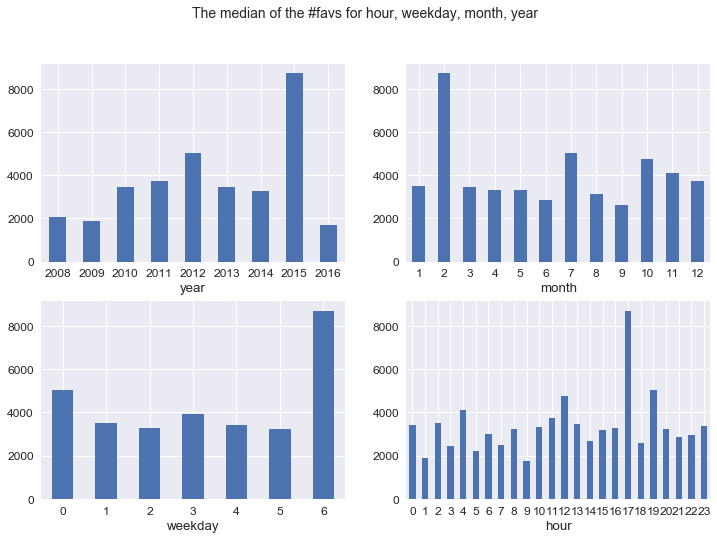

In [16]:
plt.figure(figsize=(12, 8))
plt.suptitle('The median of the #favs for hour, weekday, month, year', fontsize=14)

plt.subplot(221)
prepared_train.groupby('year').favs.max().plot.bar();
plt.xticks(rotation='horizontal');

plt.subplot(222)
prepared_train.groupby('month').favs.max().plot.bar();
plt.xticks(rotation='horizontal');

plt.subplot(223)
prepared_train.groupby('weekday').favs.max().plot.bar();
plt.xticks(rotation='horizontal');

plt.subplot(224)
prepared_train.groupby('hour').favs.max().plot.bar();
plt.xticks(rotation='horizontal');

#### Company / author

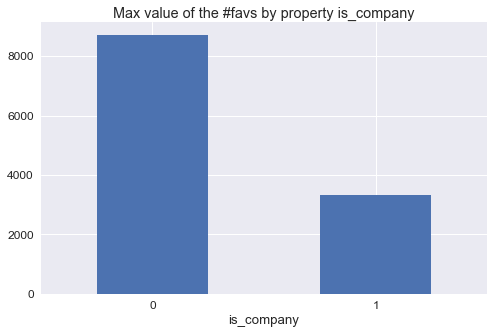

In [195]:
plt.figure(figsize=(8, 5))
plt.title('Max value of the #favs by property is_company')
prepared_train.groupby('is_company').favs.max().plot.bar();
plt.xticks(rotation='horizontal');

### Get rid from outliers

#### Number of the views

In [63]:
prepared_train = prepared_train[prepared_train.views < 600000]

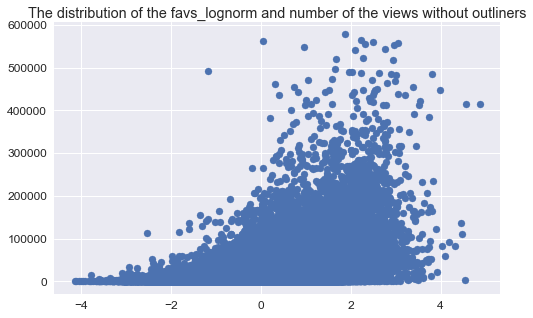

In [18]:
plt.figure(figsize=(8, 5))

plt.scatter(prepared_train.favs_lognorm, prepared_train.views);
plt.title('The distribution of the favs_lognorm and number of the views without outliers');

#### Number of the comments

In [64]:
prepared_train = prepared_train[prepared_train.comments < 1100]

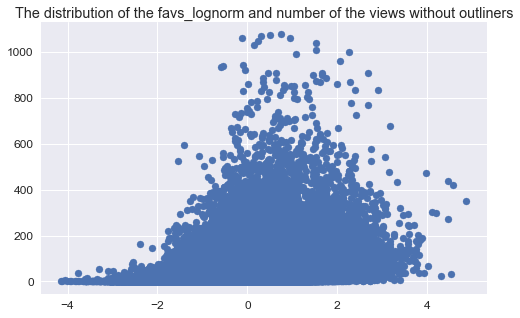

In [20]:
plt.figure(figsize=(8, 5))

plt.scatter(prepared_train.favs_lognorm, prepared_train.comments);
plt.title('The distribution of the favs_lognorm and number of the views without outliers');

In [65]:
print('{} outliers were removed from the training dataset'.format(train_df.shape[0] - prepared_train.shape[0]))

39 outliners were removed from the training dataset


### Split data for train and test

We need predict historical data. That's why we'll take for testing last 7 months from the training dataset

In [66]:
X_train = prepared_train[prepared_train.published <= '2016-04-01 00:00:00']
X_test = prepared_train[prepared_train.published > '2016-04-01 00:00:00']

y_train, y_test = X_train.favs_lognorm, X_test.favs_lognorm

### Build pipline

In [67]:
using_columns = np.concatenate([
        [
            'domain', 'is_weekend', 'is_company',
            'content_len', 'title_len', 
            'title',
        ],
        [col for col in prepared_train.columns if col.startswith('flow_')],
        [col for col in prepared_train.columns if col.startswith('hour_')],
        [col for col in prepared_train.columns if col.startswith('weekday_')],
        [col for col in prepared_train.columns if col.startswith('month_')],
        [col for col in prepared_train.columns if col.startswith('year_')],
    ])

In [68]:
pipline_columns = list(using_columns)
pipline_columns.remove('title')

In [69]:
estimator = Pipeline([(
        'feature_processing', FeatureUnion(transformer_list=[
            ('titles_processing', Pipeline([
                ('selecting', ItemSelector(key='title')),
                ('tfidf', TfidfVectorizer()),
            ])),
            ('characters_processing', Pipeline([
                ('selecting', ItemSelector(key='title')),
                ('tfidf', TfidfVectorizer(analyzer='char')),
            ])),
            ('all_feauters', Pipeline([
                ('selecting', ItemSelector(key=pipline_columns))
            ])),
        ])
     ),
    
    ('model_fitting', Ridge(random_state=42))
])

In [70]:
estimator.set_params(   
    model_fitting__alpha=1,
    
    feature_processing__characters_processing__tfidf__max_features=2000,
    feature_processing__characters_processing__tfidf__min_df=5,
    feature_processing__characters_processing__tfidf__ngram_range=(1, 3),
    
    feature_processing__titles_processing__tfidf__max_features=18000,
    feature_processing__titles_processing__tfidf__min_df=3,
    feature_processing__titles_processing__tfidf__ngram_range=(1, 3)
);

In [71]:
%%time
estimator.fit(X_train, y_train)

CPU times: user 1min 30s, sys: 2.26 s, total: 1min 32s
Wall time: 1min 33s


Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('titles_processing', Pipeline(steps=[('selecting', ItemSelector(key='title')), ('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='... fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001))])

In [302]:
# Public score value is 0.62294
estimate_model(estimator)

Train error: 0.460321695281
Test error: 0.594892883874


#### Create submission

In [73]:
estimator.fit(prepared_train, prepared_train.favs_lognorm);

In [76]:
make_submission(estimator, 'final')

submission_final.csv successfully created
